<a href="https://colab.research.google.com/github/eunjeechoi/AI_project/blob/main/Sales_Analysis_(Shopping_Mall).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sales Analysis(Shopping Mall)
## EDA & Preprocessing

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
import glob
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from category_encoders import OrdinalEncoder
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

### 예측하고자 하는 타겟값이 실수, 즉 숫자인 경우에 해당되므로 회귀에 해당하는 모델인 것을 확인할 수 있음

In [ ]:
train= pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train.shape, test.shape

((6255, 13), (180, 12))

In [ ]:
train.head()

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
0,1,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,8.106,False,1643690.90
1,2,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,8.106,True,1641957.44
2,3,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,8.106,False,1611968.17
3,4,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,8.106,False,1409727.59
4,5,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,8.106,False,1554806.68


In [ ]:
test.head()

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday
0,1,1,05/10/2012,68.55,3.617,8077.89,NaN,18.22,3617.43,3626.14,6.573,False
1,2,1,12/10/2012,62.99,3.601,2086.18,NaN,8.11,602.36,5926.45,6.573,False
2,3,1,19/10/2012,67.97,3.594,950.33,NaN,4.93,80.25,2312.85,6.573,False
3,4,1,26/10/2012,69.16,3.506,2585.85,31.75,6.00,1057.16,1305.01,6.573,False
4,5,2,05/10/2012,70.27,3.617,6037.76,NaN,10.04,3027.37,3853.40,6.170,False


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6255 entries, 0 to 6254
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            6255 non-null   int64  
 1   Store         6255 non-null   int64  
 2   Date          6255 non-null   object 
 3   Temperature   6255 non-null   float64
 4   Fuel_Price    6255 non-null   float64
 5   Promotion1    2102 non-null   float64
 6   Promotion2    1592 non-null   float64
 7   Promotion3    1885 non-null   float64
 8   Promotion4    1819 non-null   float64
 9   Promotion5    2115 non-null   float64
 10  Unemployment  6255 non-null   float64
 11  IsHoliday     6255 non-null   bool   
 12  Weekly_Sales  6255 non-null   float64
dtypes: bool(1), float64(9), int64(2), object(1)
memory usage: 592.6+ KB


- id : 샘플 아이디
- Store : 쇼핑몰 지점
- Date : 주 단위(Weekly) 날짜
- Temperature : 해당 쇼핑몰 주변 기온
- Fuel_Price : 해당 쇼핑몰 주변 연료 가격
- Promotion 1~5 : 해당 쇼핑몰의 비식별화된 프로모션 정보
- Unemployment : 해당 쇼핑몰 지역의 실업률
- IsHoliday : 해당 기간의 공휴일 포함 여부
- Weekly_Sales : 주간 매출액 (목표 예측값)

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            180 non-null    int64  
 1   Store         180 non-null    int64  
 2   Date          180 non-null    object 
 3   Temperature   180 non-null    float64
 4   Fuel_Price    180 non-null    float64
 5   Promotion1    178 non-null    float64
 6   Promotion2    45 non-null     float64
 7   Promotion3    161 non-null    float64
 8   Promotion4    146 non-null    float64
 9   Promotion5    180 non-null    float64
 10  Unemployment  180 non-null    float64
 11  IsHoliday     180 non-null    bool   
dtypes: bool(1), float64(8), int64(2), object(1)
memory usage: 15.8+ KB


결측치를 확인하면, 다른 변수들은 결측치가 없으나 Promotion 속성에 결측치가 존재하는걸 확인할 수 있음

In [ ]:
train.corr(method='pearson')

,id,Store,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,IsHoliday,Weekly_Sales,Year,Month,Day,Cel,Weekly_Sales_log1p,Unemployment_High,Unemployment_Low,Unemployment_Middle
id,1.000000e+00,9.997531e-01,-0.019554,0.075666,-0.077199,-0.063457,-0.024997,-0.058339,-0.010054,1.475431e-16,-0.335276,2.088941e-02,2.182932e-03,9.905852e-04,-0.019540,-0.294782,0.215153,-0.206371,0.018394
Store,9.997531e-01,1.000000e+00,-0.022895,0.058628,-0.087662,-0.067120,-0.026226,-0.065394,-0.019681,1.547191e-16,-0.335569,1.175349e-12,1.864995e-15,7.284069e-17,-0.022879,-0.295102,0.218347,-0.211906,0.020870
Temperature,-1.955428e-02,-2.289476e-02,1.000000,0.148054,0.041091,-0.084794,-0.054089,-0.007941,0.075382,-1.555954e-01,-0.063231,6.440390e-02,2.396484e-01,2.934131e-02,0.999996,-0.091379,0.094978,-0.008739,-0.065338
Fuel_Price,7.566586e-02,5.862843e-02,0.148054,1.000000,0.449465,0.219076,0.027921,0.267250,0.330753,-7.148479e-02,0.010986,7.748028e-01,-7.928143e-02,3.080265e-02,0.148014,0.019617,-0.047057,0.059962,-0.017245
Promotion1,-7.719897e-02,-8.766210e-02,0.041091,0.449465,1.000000,0.305268,-0.024349,0.799568,0.371353,-3.038222e-02,0.265490,4.635954e-01,-6.093189e-03,-1.116656e-01,0.041050,0.296454,-0.106094,0.056460,0.031336
Promotion2,-6.345662e-02,-6.711986e-02,-0.084794,0.219076,0.305268,1.000000,-0.013820,0.168723,0.158761,1.353713e-01,0.209808,1.390138e-01,5.874185e-02,3.583710e-02,-0.084820,0.220133,-0.087847,-0.012564,0.078846
Promotion3,-2.499664e-02,-2.622612e-02,-0.054089,0.027921,-0.024349,-0.013820,1.000000,-0.017967,0.030516,2.554566e-01,0.125569,1.096121e-02,1.187580e-01,6.991584e-02,-0.054080,0.097102,-0.022420,0.005914,0.011989
Promotion4,-5.833862e-02,-6.539415e-02,-0.007941,0.267250,0.799568,0.168723,-0.017967,1.000000,0.286935,-4.819651e-03,0.191414,3.330633e-01,-5.893792e-02,-1.390975e-01,-0.007946,0.212085,-0.036401,0.062840,-0.028017
Promotion5,-1.005355e-02,-1.968114e-02,0.075382,0.330753,0.371353,0.158761,0.030516,0.286935,1.000000,-3.145714e-02,0.181400,3.924949e-01,9.149083e-02,-4.907576e-02,0.075299,0.177294,-0.092706,0.107533,-0.024524
IsHoliday,1.475431e-16,1.547191e-16,-0.155595,-0.071485,-0.030382,0.135371,0.255457,-0.004820,-0.031457,1.000000e+00,0.037066,-4.775901e-02,1.341388e-01,4.491854e-02,-0.155633,0.026999,0.007615,-0.014062,0.006678


In [ ]:
from pandas_profiling import ProfileReport
ProfileReport(train, minimal=True)

Summarize dataset:   0%|          | 0/28 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

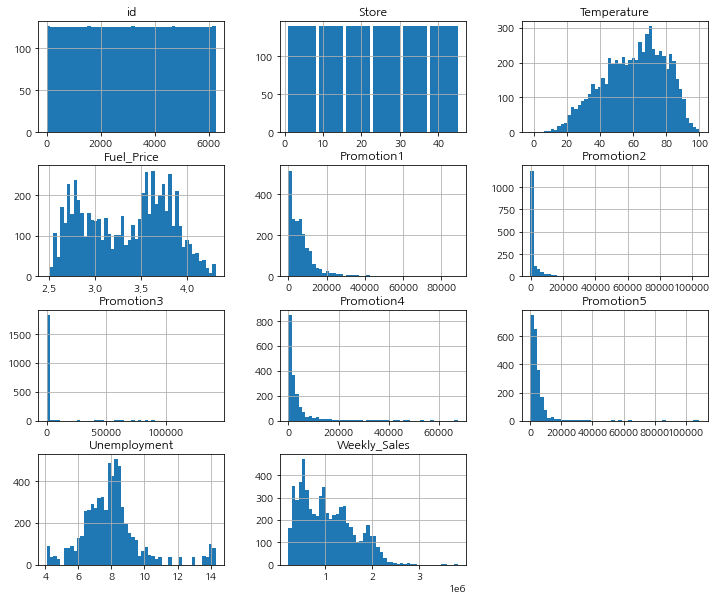

In [ ]:
t_hist=train.hist(bins=50, figsize=(12, 10))

In [ ]:
set(train["Store"].unique()) == set(test["Store"].unique())

True

쇼핑몰 지점은 `train`과 `test`가 같다라는 점을 확일할 수 있음

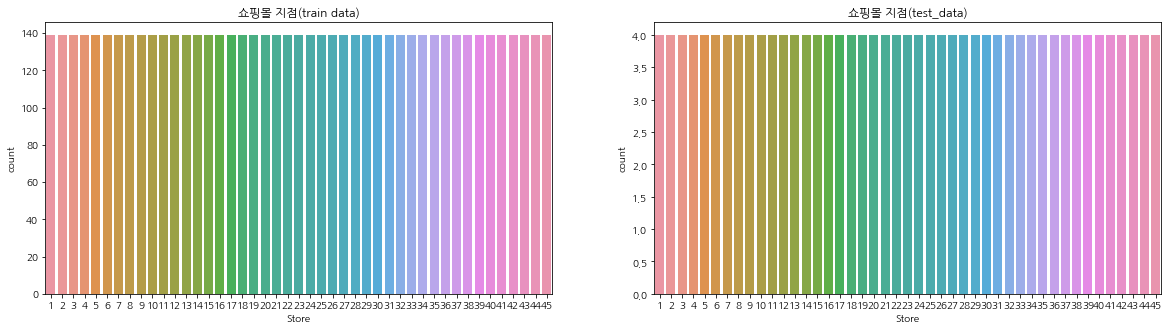

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.countplot(x=train["Store"], ax=ax[0]).set_title("쇼핑몰 지점(train data)")
sns.countplot(x=test["Store"], ax=ax[1]).set_title("쇼핑몰 지점(test_data)")
plt.show()

In [ ]:
train["Date"] = pd.to_datetime(train["Date"], format="%d/%m/%Y")
test["Date"] = pd.to_datetime(test["Date"], format="%d/%m/%Y")

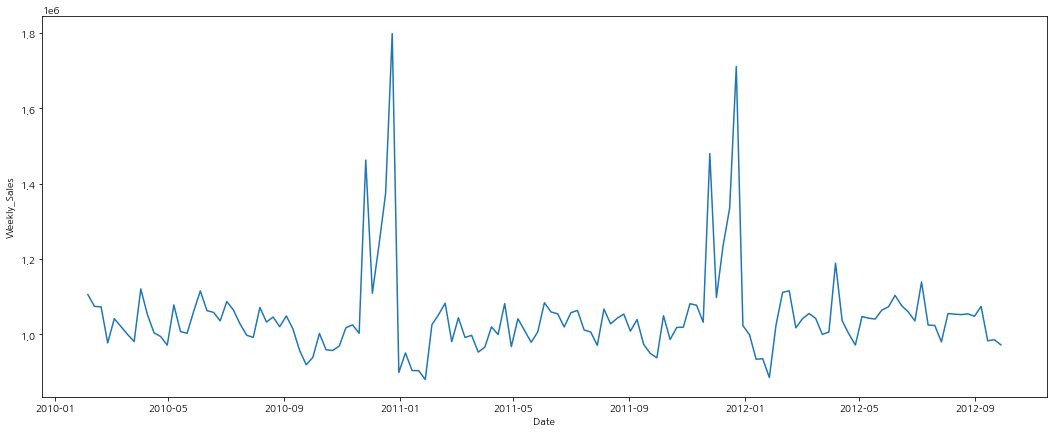

In [ ]:
plt.figure(figsize=(18, 7))
sns.lineplot(data=train, x="Date", y="Weekly_Sales", ci=None)
plt.show()

특정 기간에서 매출이 급격히 오르거나, 내려가는 경우를 확인


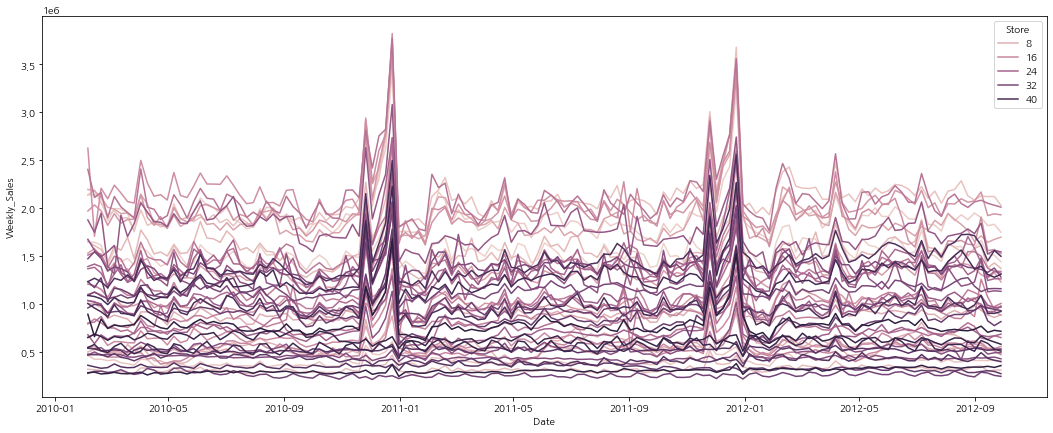

In [ ]:
plt.figure(figsize=(18, 7))
sns.lineplot(data=train, x="Date", y="Weekly_Sales", ci=None, hue="Store")
plt.show()

쇼핑몰을 지점별로 나누어서 찍었을 경우, 특정 매장의 매출이 급격하게 변하는 시점이 있다는 것을 확인

Data 전처리 => 연도, 월, 일로 쪼갬

In [ ]:
train["Year"] = train["Date"].dt.year
test["Year"] = test["Date"].dt.year

train["Month"] = train["Date"].dt.month
test["Month"] = test["Date"].dt.month

train["Day"] = train["Date"].dt.day
test["Day"] = test["Date"].dt.day

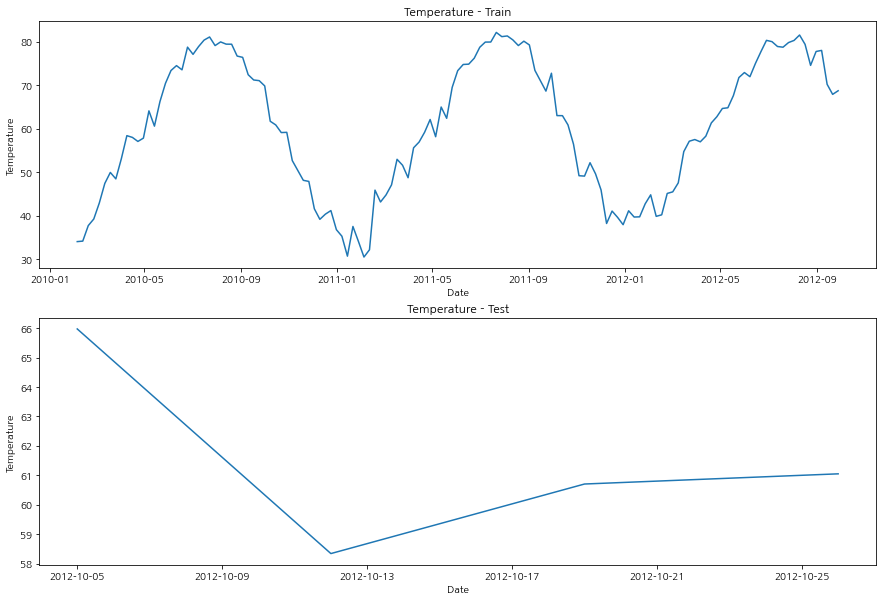

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
sns.lineplot(data=train, x="Date", y="Temperature", ci=None, ax=ax[0]).set_title("Temperature - Train")
sns.lineplot(data=test, x="Date", y="Temperature", ci=None, ax=ax[1]).set_title("Temperature - Test")
plt.show()

기온의 값이 섭씨가 아닌 것을 시각화로 알 수 있음
=> 기온의 값이 섭씨에서 화씨로 전처리

In [ ]:
train["Cel"] = train["Temperature"].apply(lambda x: round((x-32)*5/9, 1))
test["Cel"] = test["Temperature"].apply(lambda x: round((x-32)*5/9, 1))

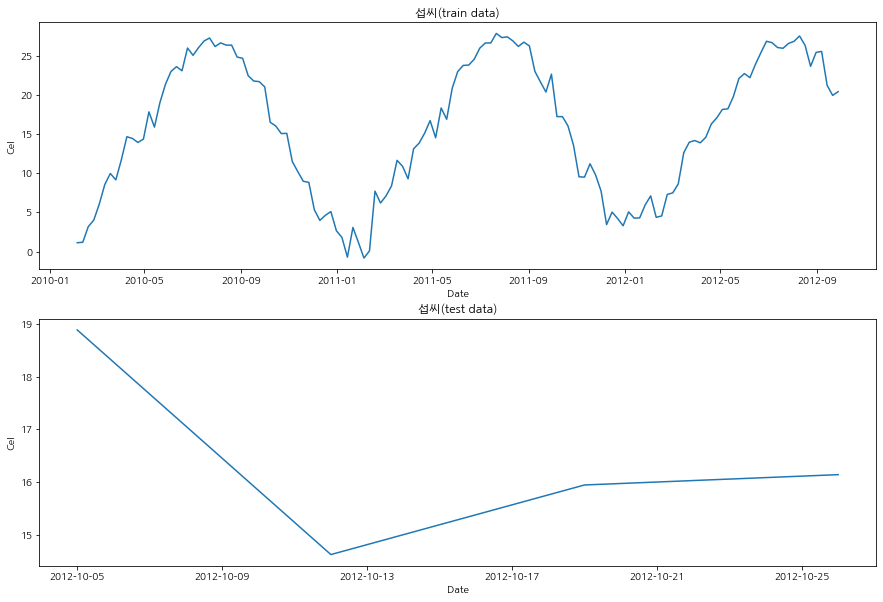

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
sns.lineplot(data=train, x="Date", y="Cel", ci=None, ax=ax[0]).set_title("섭씨(train data)")
sns.lineplot(data=test, x="Date", y="Cel", ci=None, ax=ax[1]).set_title("섭씨(test data)")
plt.show()

기존 데이터에서 섭씨로 변환된 것을 볼 수 있음

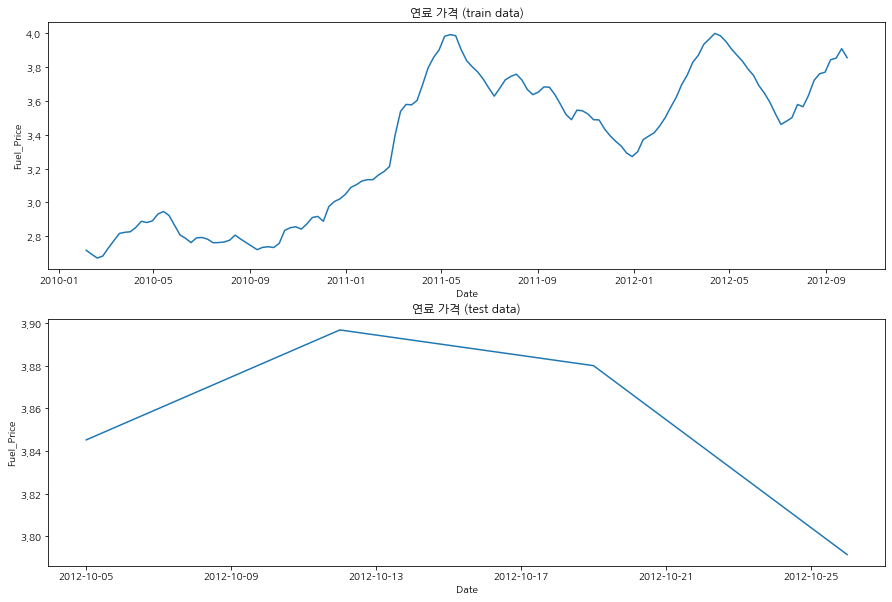

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
sns.lineplot(data=train, x="Date", y="Fuel_Price", ci=None, ax=ax[0]).set_title("연료 가격 (train data)")
sns.lineplot(data=test, x="Date", y="Fuel_Price", ci=None, ax=ax[1]).set_title("연료 가격 (test data)")
plt.show()

In [ ]:
promotion = ["Promotion1", "Promotion2", "Promotion3", "Promotion4", "Promotion5"]
data = [train, test]

for pro in promotion:
    print(f"{pro}: {train[pro].isnull().sum()}")
print('\n')
for pro in promotion:
    print(f"{pro}: {test[pro].isnull().sum()}")

Promotion1: 4153
Promotion2: 4663
Promotion3: 4370
Promotion4: 4436
Promotion5: 4140


Promotion1: 2
Promotion2: 135
Promotion3: 19
Promotion4: 34
Promotion5: 0


Promotion=> 결측치 확인

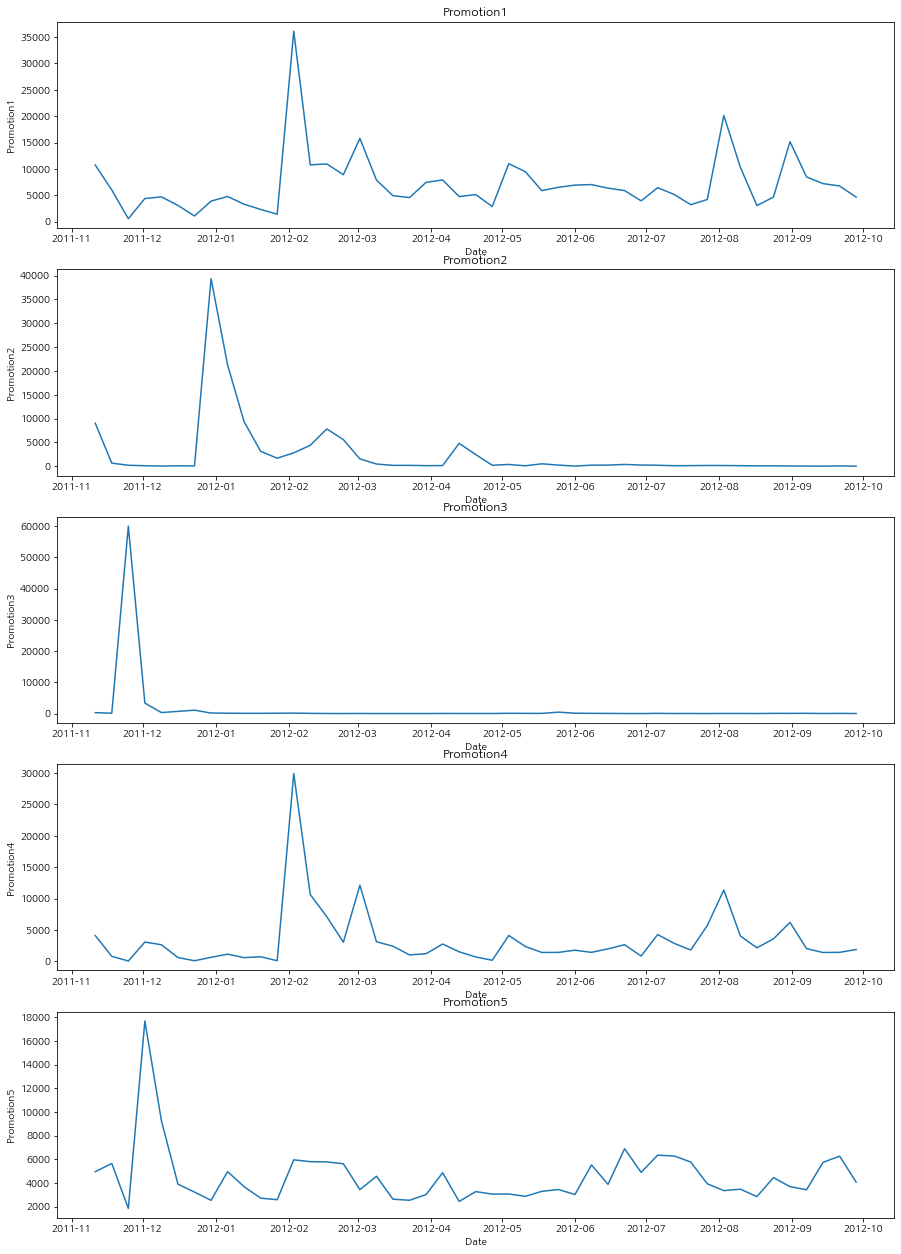

In [ ]:
fig, ax = plt.subplots(len(promotion), 1, figsize=(15, 22))
for col, ax in zip(promotion, ax):
    sns.lineplot(data=train, x="Date", y=col, ci=None, ax=ax).set_title(f"{col}")
plt.show()

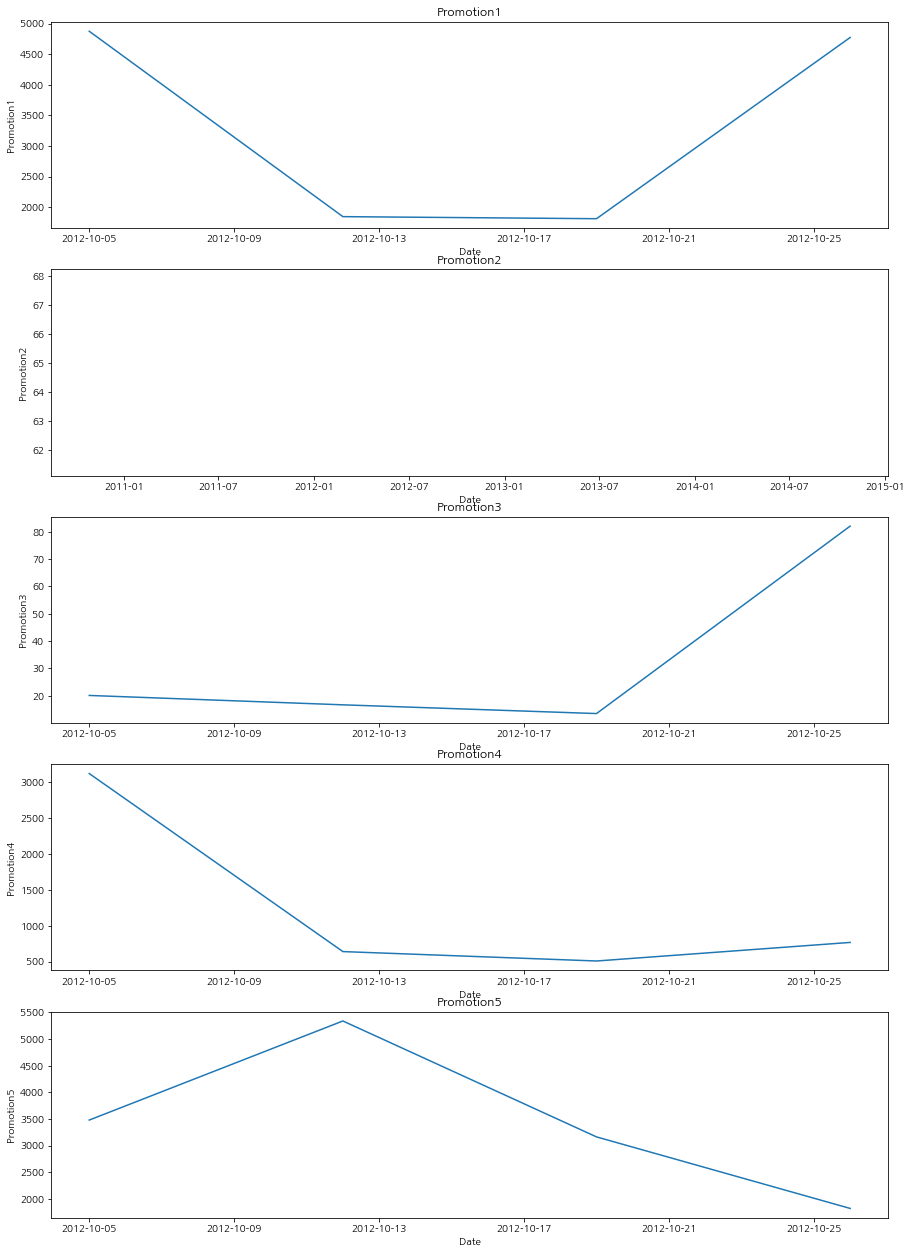

In [ ]:
fig, ax = plt.subplots(len(promotion), 1, figsize=(15, 22))
for col, ax in zip(promotion, ax):
    sns.lineplot(data=test, x="Date", y=col, ci=None, ax=ax).set_title(f"{col}")
plt.show()

Promotion들은 2011년 11월 이후에 발생한 이벤트라고 생각할 수 있음 -> 2011년 11월 이전의 Promotion의 결측치는 0으로 처리하고, 해당하지 않는 데이터는 선형 보간법을 이용  
선형 보간을 위해 train, test를 임시로 합치고 결측치 처리 후 다시 나눠줌

In [ ]:
temp = pd.concat([train, test])
temp.shape

(6435, 17)

In [ ]:
def fill_promotion(cols):
    year, promotion = cols[0], cols[1]
    if pd.isnull(promotion):
        if year<2011: return 0
        else: return promotion
    else:
        return promotion

In [ ]:
for p in promotion:
    temp[p] = temp[["Year", p]].apply(fill_promotion, axis=1)

In [ ]:
# 선형 보간
temp[promotion] = temp[promotion].interpolate("values")

In [ ]:
train = temp.iloc[:train.shape[0]]
test = temp.iloc[train.shape[0]:]

train.shape, test.shape

((6255, 17), (180, 17))

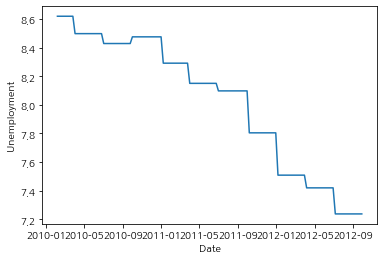

In [ ]:
unemployment_plot= sns.lineplot(data=train, x="Date", y="Unemployment", ci=None)

실업률은 감소하는 추세임

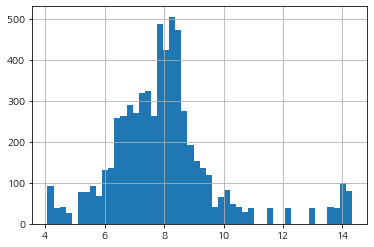

In [ ]:
unem_hist= train["Unemployment"].hist(bins=50)

In [ ]:
train["Unemployment"].describe()

count    6255.000000
mean        8.029236
std         1.874875
min         4.077000
25%         6.916500
50%         7.906000
75%         8.622000
max        14.313000
Name: Unemployment, dtype: float64

In [ ]:
def get_band_unemployment(col):
    if col<7: return "Low"
    elif col>=7 and col<=9: return "Middle"
    else: return "High"

In [ ]:
train["Unemployment"] = train["Unemployment"].apply(get_band_unemployment)
test["Unemployment"] = test["Unemployment"].apply(get_band_unemployment)

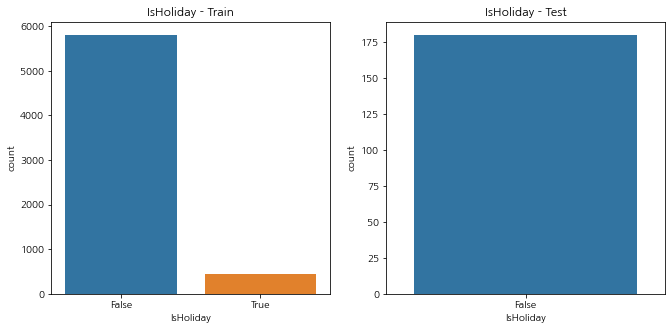

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))
sns.countplot(x=train["IsHoliday"], ax=ax[0]).set_title("IsHoliday - Train")
sns.countplot(x=test["IsHoliday"], ax=ax[1]).set_title("IsHoliday - Test")
plt.show()

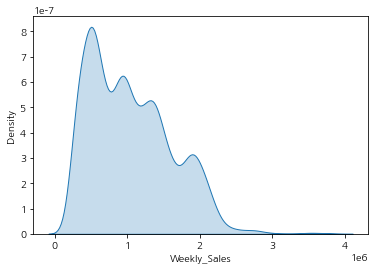

In [ ]:
sales_plot = sns.kdeplot(train["Weekly_Sales"], shade=True)

- 로그 스케일링 적용

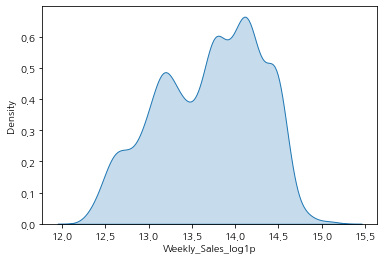

In [ ]:
train["Weekly_Sales_log1p"] = np.log1p(train["Weekly_Sales"])
sales_logplot= sns.kdeplot(train["Weekly_Sales_log1p"], shade=True)

In [ ]:
train = pd.get_dummies(train, columns=["Unemployment"])
test = pd.get_dummies(test, columns=["Unemployment"])

label = "Weekly_Sales_log1p"
features = train.columns.tolist()
features.remove(label)
features.remove("id")
features.remove("Date")
features.remove("Weekly_Sales")
features.remove("Temperature")
features

['Store',
 'Fuel_Price',
 'Promotion1',
 'Promotion2',
 'Promotion3',
 'Promotion4',
 'Promotion5',
 'IsHoliday',
 'Year',
 'Month',
 'Day',
 'Cel',
 'Unemployment_High',
 'Unemployment_Low',
 'Unemployment_Middle']

# Modeling

1) randomforest 모델

2) catboost 모델

3) xgb 모델

4) 스태킹(앙상블) 모델

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train[features], train[label], test_size=0.2)

print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}\nX_test: {X_val.shape}\ny_val: {y_val.shape}")

X_train: (5004, 15)
y_train: (5004,)
X_test: (1251, 15)
y_val: (1251,)


In [ ]:
from sklearn.model_selection import train_test_split
train0, test = train_test_split(credit, train_size = 0.80, test_size = 0.20, random_state = 1)
train, val = train_test_split(train0, train_size = 0.75, test_size = 0.25, random_state = 1)
print(train.shape, val.shape ,test.shape)

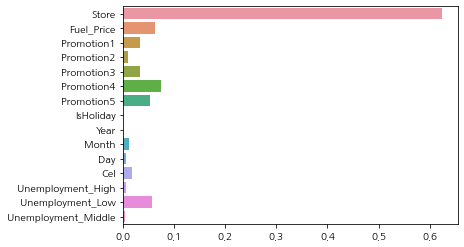

In [ ]:
#randomforest
reg_rf = RandomForestRegressor()

pred_rf = reg_rf.fit(X_train, y_train).predict(X_val)

reg_plot= sns.barplot(x=reg_rf.feature_importances_, y=reg_rf.feature_names_in_)

In [ ]:
np.sqrt(mean_squared_error(y_val, pred_rf)) #RMSE 평가지표

0.13520716538899966

In [ ]:
#Catboost

reg_cb = CatBoostRegressor(verbose=0)

pred_cb = reg_cb.fit(X_train, y_train).predict(X_val)

In [ ]:
np.sqrt(mean_squared_error(y_val, pred_cb)) #RMSE 평가지표

0.08487346422123558

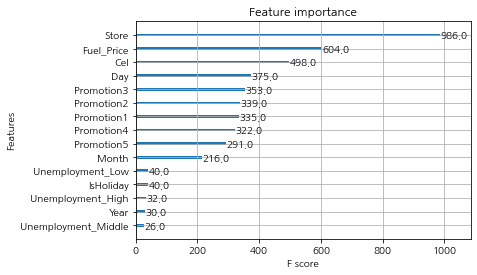

In [ ]:
#xgb
reg_xgb = XGBRegressor()

pred_xgb = reg_xgb.fit(X_train, y_train).predict(X_val)

xgb_plot = xgb.plot_importance(reg_xgb)

In [ ]:
np.sqrt(mean_squared_error(y_val, pred_xgb))#RMSE 평가지표

0.09400193443950032

# 스태킹(앙상블)

- 개별 알고리즘의 예측한 데이터를 기반으로 다시 예측을 수행하는 방법

In [ ]:
pred_stacking = (0.33*pred_rf) + (0.33*pred_cb) + (0.33*pred_xgb)

np.sqrt(mean_squared_error(y_val, pred_stacking)) 

0.16491766302806776

## 최종 RMSE 평가지표

1) randomforest: 0.13520716538899966

2) catboost: 0.08487346422123558

3) xgb: 0.09400193443950032

4) ensemble(스태킹): 0.16491766302806776

=> catboost 최종모델 선정

In [ ]:
#파이프라인 생성
pipe_cb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    CatBoostRegressor()
)

pipe_cb.fit(X_train, y_train)
cb_pred = pipe_cb.predict(X_val)

#캣부스트 모델 평가지표
cb_train_accuracy = pipe_cb.score(X_train, y_train)
cb_val_accuracy = pipe_cb.score(X_val, y_val)

print('캣부스트 모델 훈련 정확도: ', cb_train_accuracy)
print('캣부스트 모델 검증 정확도: ', cb_val_accuracy)

Learning rate set to 0.052805
0:	learn: 0.5769818	total: 3.17ms	remaining: 3.17s
1:	learn: 0.5655126	total: 4.96ms	remaining: 2.48s
2:	learn: 0.5547765	total: 6.54ms	remaining: 2.17s
3:	learn: 0.5445951	total: 8.25ms	remaining: 2.05s
4:	learn: 0.5356666	total: 9.86ms	remaining: 1.96s
5:	learn: 0.5277403	total: 11.5ms	remaining: 1.9s
6:	learn: 0.5195851	total: 13.3ms	remaining: 1.88s
7:	learn: 0.5112766	total: 15.3ms	remaining: 1.89s
8:	learn: 0.5036107	total: 16.9ms	remaining: 1.86s
9:	learn: 0.4967366	total: 18.6ms	remaining: 1.84s
10:	learn: 0.4911453	total: 20.8ms	remaining: 1.87s
11:	learn: 0.4840411	total: 23.1ms	remaining: 1.9s
12:	learn: 0.4780084	total: 25.3ms	remaining: 1.92s
13:	learn: 0.4705660	total: 28ms	remaining: 1.97s
14:	learn: 0.4658622	total: 30ms	remaining: 1.97s
15:	learn: 0.4601054	total: 31.9ms	remaining: 1.96s
16:	learn: 0.4541228	total: 33.7ms	remaining: 1.95s
17:	learn: 0.4494193	total: 35.6ms	remaining: 1.94s
18:	learn: 0.4447442	total: 37.6ms	remaining: 1.94

200:	learn: 0.1768692	total: 363ms	remaining: 1.44s
201:	learn: 0.1762385	total: 365ms	remaining: 1.44s
202:	learn: 0.1751121	total: 368ms	remaining: 1.45s
203:	learn: 0.1746053	total: 370ms	remaining: 1.44s
204:	learn: 0.1741111	total: 372ms	remaining: 1.44s
205:	learn: 0.1736862	total: 374ms	remaining: 1.44s
206:	learn: 0.1732610	total: 376ms	remaining: 1.44s
207:	learn: 0.1729063	total: 378ms	remaining: 1.44s
208:	learn: 0.1726171	total: 379ms	remaining: 1.43s
209:	learn: 0.1722023	total: 381ms	remaining: 1.44s
210:	learn: 0.1711636	total: 384ms	remaining: 1.44s
211:	learn: 0.1708253	total: 386ms	remaining: 1.44s
212:	learn: 0.1704613	total: 388ms	remaining: 1.43s
213:	learn: 0.1700947	total: 390ms	remaining: 1.43s
214:	learn: 0.1695875	total: 392ms	remaining: 1.43s
215:	learn: 0.1687816	total: 394ms	remaining: 1.43s
216:	learn: 0.1683356	total: 397ms	remaining: 1.43s
217:	learn: 0.1678869	total: 398ms	remaining: 1.43s
218:	learn: 0.1675434	total: 402ms	remaining: 1.44s
219:	learn: 

396:	learn: 0.1086175	total: 749ms	remaining: 1.14s
397:	learn: 0.1082790	total: 751ms	remaining: 1.14s
398:	learn: 0.1081639	total: 753ms	remaining: 1.13s
399:	learn: 0.1080310	total: 755ms	remaining: 1.13s
400:	learn: 0.1075797	total: 756ms	remaining: 1.13s
401:	learn: 0.1074541	total: 758ms	remaining: 1.13s
402:	learn: 0.1071533	total: 761ms	remaining: 1.13s
403:	learn: 0.1069563	total: 763ms	remaining: 1.13s
404:	learn: 0.1068180	total: 765ms	remaining: 1.12s
405:	learn: 0.1067029	total: 767ms	remaining: 1.12s
406:	learn: 0.1065747	total: 769ms	remaining: 1.12s
407:	learn: 0.1061904	total: 770ms	remaining: 1.12s
408:	learn: 0.1057839	total: 772ms	remaining: 1.11s
409:	learn: 0.1056571	total: 774ms	remaining: 1.11s
410:	learn: 0.1053045	total: 776ms	remaining: 1.11s
411:	learn: 0.1051886	total: 777ms	remaining: 1.11s
412:	learn: 0.1049878	total: 779ms	remaining: 1.11s
413:	learn: 0.1048047	total: 781ms	remaining: 1.1s
414:	learn: 0.1044809	total: 784ms	remaining: 1.1s
415:	learn: 0.

591:	learn: 0.0816343	total: 1.14s	remaining: 783ms
592:	learn: 0.0815594	total: 1.14s	remaining: 781ms
593:	learn: 0.0814740	total: 1.14s	remaining: 778ms
594:	learn: 0.0814037	total: 1.14s	remaining: 776ms
595:	learn: 0.0813139	total: 1.14s	remaining: 774ms
596:	learn: 0.0812065	total: 1.14s	remaining: 772ms
597:	learn: 0.0811429	total: 1.15s	remaining: 770ms
598:	learn: 0.0810352	total: 1.15s	remaining: 768ms
599:	learn: 0.0809068	total: 1.15s	remaining: 766ms
600:	learn: 0.0808150	total: 1.15s	remaining: 764ms
601:	learn: 0.0807421	total: 1.15s	remaining: 762ms
602:	learn: 0.0806679	total: 1.15s	remaining: 760ms
603:	learn: 0.0805998	total: 1.16s	remaining: 758ms
604:	learn: 0.0805481	total: 1.16s	remaining: 756ms
605:	learn: 0.0804642	total: 1.16s	remaining: 754ms
606:	learn: 0.0803922	total: 1.16s	remaining: 752ms
607:	learn: 0.0803389	total: 1.16s	remaining: 750ms
608:	learn: 0.0802551	total: 1.17s	remaining: 748ms
609:	learn: 0.0801663	total: 1.17s	remaining: 746ms
610:	learn: 

778:	learn: 0.0684684	total: 1.52s	remaining: 431ms
779:	learn: 0.0684241	total: 1.52s	remaining: 430ms
780:	learn: 0.0684000	total: 1.52s	remaining: 428ms
781:	learn: 0.0683418	total: 1.53s	remaining: 426ms
782:	learn: 0.0682869	total: 1.53s	remaining: 424ms
783:	learn: 0.0682350	total: 1.53s	remaining: 422ms
784:	learn: 0.0681491	total: 1.53s	remaining: 420ms
785:	learn: 0.0681033	total: 1.53s	remaining: 418ms
786:	learn: 0.0680715	total: 1.53s	remaining: 416ms
787:	learn: 0.0680377	total: 1.54s	remaining: 414ms
788:	learn: 0.0679728	total: 1.54s	remaining: 412ms
789:	learn: 0.0678803	total: 1.54s	remaining: 410ms
790:	learn: 0.0678300	total: 1.54s	remaining: 408ms
791:	learn: 0.0677803	total: 1.54s	remaining: 406ms
792:	learn: 0.0677499	total: 1.55s	remaining: 404ms
793:	learn: 0.0677009	total: 1.55s	remaining: 402ms
794:	learn: 0.0676441	total: 1.55s	remaining: 400ms
795:	learn: 0.0676209	total: 1.55s	remaining: 398ms
796:	learn: 0.0675625	total: 1.55s	remaining: 396ms
797:	learn: 

978:	learn: 0.0596597	total: 1.91s	remaining: 41.1ms
979:	learn: 0.0596211	total: 1.92s	remaining: 39.1ms
980:	learn: 0.0596045	total: 1.92s	remaining: 37.2ms
981:	learn: 0.0595360	total: 1.92s	remaining: 35.2ms
982:	learn: 0.0594845	total: 1.92s	remaining: 33.2ms
983:	learn: 0.0594648	total: 1.93s	remaining: 31.3ms
984:	learn: 0.0594027	total: 1.93s	remaining: 29.4ms
985:	learn: 0.0593786	total: 1.93s	remaining: 27.4ms
986:	learn: 0.0593398	total: 1.93s	remaining: 25.5ms
987:	learn: 0.0592862	total: 1.93s	remaining: 23.5ms
988:	learn: 0.0592491	total: 1.94s	remaining: 21.5ms
989:	learn: 0.0592255	total: 1.94s	remaining: 19.6ms
990:	learn: 0.0591878	total: 1.94s	remaining: 17.6ms
991:	learn: 0.0591533	total: 1.94s	remaining: 15.7ms
992:	learn: 0.0591251	total: 1.94s	remaining: 13.7ms
993:	learn: 0.0590864	total: 1.95s	remaining: 11.8ms
994:	learn: 0.0590138	total: 1.95s	remaining: 9.81ms
995:	learn: 0.0589581	total: 1.95s	remaining: 7.85ms
996:	learn: 0.0589253	total: 1.96s	remaining: 

In [ ]:
model = pipe_cb

model.fit(X_train, y_train)
y_pred = model.predict(X_val)

Learning rate set to 0.052805
0:	learn: 0.5769818	total: 2.38ms	remaining: 2.38s
1:	learn: 0.5655126	total: 4.53ms	remaining: 2.26s
2:	learn: 0.5547765	total: 6.29ms	remaining: 2.09s
3:	learn: 0.5445951	total: 7.97ms	remaining: 1.99s
4:	learn: 0.5356666	total: 9.83ms	remaining: 1.96s
5:	learn: 0.5277403	total: 11.7ms	remaining: 1.93s
6:	learn: 0.5195851	total: 13.4ms	remaining: 1.9s
7:	learn: 0.5112766	total: 15.1ms	remaining: 1.88s
8:	learn: 0.5036107	total: 16.9ms	remaining: 1.85s
9:	learn: 0.4967366	total: 18.7ms	remaining: 1.85s
10:	learn: 0.4911453	total: 20.3ms	remaining: 1.83s
11:	learn: 0.4840411	total: 22ms	remaining: 1.81s
12:	learn: 0.4780084	total: 23.8ms	remaining: 1.8s
13:	learn: 0.4705660	total: 25.3ms	remaining: 1.78s
14:	learn: 0.4658622	total: 26.8ms	remaining: 1.76s
15:	learn: 0.4601054	total: 28.4ms	remaining: 1.74s
16:	learn: 0.4541228	total: 29.9ms	remaining: 1.73s
17:	learn: 0.4494193	total: 31.7ms	remaining: 1.73s
18:	learn: 0.4447442	total: 33.3ms	remaining: 1.

200:	learn: 0.1768692	total: 348ms	remaining: 1.38s
201:	learn: 0.1762385	total: 350ms	remaining: 1.38s
202:	learn: 0.1751121	total: 352ms	remaining: 1.38s
203:	learn: 0.1746053	total: 354ms	remaining: 1.38s
204:	learn: 0.1741111	total: 355ms	remaining: 1.38s
205:	learn: 0.1736862	total: 357ms	remaining: 1.38s
206:	learn: 0.1732610	total: 358ms	remaining: 1.37s
207:	learn: 0.1729063	total: 360ms	remaining: 1.37s
208:	learn: 0.1726171	total: 362ms	remaining: 1.37s
209:	learn: 0.1722023	total: 364ms	remaining: 1.37s
210:	learn: 0.1711636	total: 365ms	remaining: 1.37s
211:	learn: 0.1708253	total: 367ms	remaining: 1.36s
212:	learn: 0.1704613	total: 369ms	remaining: 1.36s
213:	learn: 0.1700947	total: 371ms	remaining: 1.36s
214:	learn: 0.1695875	total: 373ms	remaining: 1.36s
215:	learn: 0.1687816	total: 374ms	remaining: 1.36s
216:	learn: 0.1683356	total: 376ms	remaining: 1.36s
217:	learn: 0.1678869	total: 378ms	remaining: 1.36s
218:	learn: 0.1675434	total: 380ms	remaining: 1.35s
219:	learn: 

407:	learn: 0.1061904	total: 734ms	remaining: 1.06s
408:	learn: 0.1057839	total: 736ms	remaining: 1.06s
409:	learn: 0.1056571	total: 738ms	remaining: 1.06s
410:	learn: 0.1053045	total: 740ms	remaining: 1.06s
411:	learn: 0.1051886	total: 742ms	remaining: 1.06s
412:	learn: 0.1049878	total: 744ms	remaining: 1.06s
413:	learn: 0.1048047	total: 746ms	remaining: 1.05s
414:	learn: 0.1044809	total: 748ms	remaining: 1.05s
415:	learn: 0.1042408	total: 749ms	remaining: 1.05s
416:	learn: 0.1040229	total: 751ms	remaining: 1.05s
417:	learn: 0.1038115	total: 753ms	remaining: 1.05s
418:	learn: 0.1035777	total: 756ms	remaining: 1.05s
419:	learn: 0.1034143	total: 758ms	remaining: 1.05s
420:	learn: 0.1032980	total: 759ms	remaining: 1.04s
421:	learn: 0.1031313	total: 761ms	remaining: 1.04s
422:	learn: 0.1028495	total: 763ms	remaining: 1.04s
423:	learn: 0.1027174	total: 765ms	remaining: 1.04s
424:	learn: 0.1026359	total: 767ms	remaining: 1.04s
425:	learn: 0.1025137	total: 769ms	remaining: 1.04s
426:	learn: 

613:	learn: 0.0798236	total: 1.12s	remaining: 703ms
614:	learn: 0.0797501	total: 1.12s	remaining: 702ms
615:	learn: 0.0796901	total: 1.12s	remaining: 700ms
616:	learn: 0.0796153	total: 1.12s	remaining: 698ms
617:	learn: 0.0795114	total: 1.13s	remaining: 696ms
618:	learn: 0.0794382	total: 1.13s	remaining: 694ms
619:	learn: 0.0793880	total: 1.13s	remaining: 693ms
620:	learn: 0.0793079	total: 1.13s	remaining: 691ms
621:	learn: 0.0792517	total: 1.13s	remaining: 689ms
622:	learn: 0.0791101	total: 1.14s	remaining: 687ms
623:	learn: 0.0790613	total: 1.14s	remaining: 686ms
624:	learn: 0.0789875	total: 1.14s	remaining: 684ms
625:	learn: 0.0788588	total: 1.14s	remaining: 682ms
626:	learn: 0.0787842	total: 1.14s	remaining: 680ms
627:	learn: 0.0787077	total: 1.14s	remaining: 678ms
628:	learn: 0.0786130	total: 1.15s	remaining: 676ms
629:	learn: 0.0785521	total: 1.15s	remaining: 675ms
630:	learn: 0.0784472	total: 1.15s	remaining: 673ms
631:	learn: 0.0783327	total: 1.15s	remaining: 671ms
632:	learn: 

817:	learn: 0.0665156	total: 1.5s	remaining: 334ms
818:	learn: 0.0664727	total: 1.5s	remaining: 332ms
819:	learn: 0.0664433	total: 1.51s	remaining: 331ms
820:	learn: 0.0664117	total: 1.51s	remaining: 329ms
821:	learn: 0.0663751	total: 1.51s	remaining: 327ms
822:	learn: 0.0663393	total: 1.51s	remaining: 325ms
823:	learn: 0.0663027	total: 1.51s	remaining: 323ms
824:	learn: 0.0662673	total: 1.52s	remaining: 322ms
825:	learn: 0.0662234	total: 1.52s	remaining: 320ms
826:	learn: 0.0661857	total: 1.52s	remaining: 318ms
827:	learn: 0.0661268	total: 1.52s	remaining: 316ms
828:	learn: 0.0660799	total: 1.52s	remaining: 314ms
829:	learn: 0.0660389	total: 1.52s	remaining: 312ms
830:	learn: 0.0659883	total: 1.53s	remaining: 311ms
831:	learn: 0.0659174	total: 1.53s	remaining: 309ms
832:	learn: 0.0658463	total: 1.53s	remaining: 307ms
833:	learn: 0.0658199	total: 1.53s	remaining: 305ms
834:	learn: 0.0657702	total: 1.53s	remaining: 303ms
835:	learn: 0.0657310	total: 1.54s	remaining: 301ms
836:	learn: 0.